In [1]:
import json
import web3
import ipdb
import os

#from web3 import Web3
from web3 import Web3, HTTPProvider
from solc import compile_source
from web3.contract import ConciseContract

import pandas as pd
import time
import random

import numpy as np

data = pd.read_csv("Llaves.csv") 

public_keys = data['Llave Publica']
private_keys = data['Llave Privada']

w3 = Web3(HTTPProvider("https://rinkeby.infura.io/v3/4c0ec7f1412a489d91e1934c66ebf5b1"))

## Coops

In [2]:
# Solidity source code
Coops_source_code = '''
pragma solidity ^0.4.24;

//import "./Owned.sol";
//import "./CrowdFunding.sol";

// ----------------------------------------------------------------------------
// 'Coops' token contract
//
// Deployed to : 0xdD870fA1b7C4700F2BD7f44238821C26f7392148
// Symbol      : Coops
// Name        : Coops Token
// Total supply: 1000000000
// Decimals    : 0
//
// Enjoy.
//
// (c) by Moritz Neto with BokkyPooBah / Bok Consulting Pty Ltd Au 2017. The MIT Licence.
// ----------------------------------------------------------------------------


// ----------------------------------------------------------------------------
// Safe maths
// ----------------------------------------------------------------------------
contract SafeMath {
    function safeAdd(uint a, uint b) public pure returns (uint c) {
        c = a + b;
        require(c >= a);
    }
    function safeSub(uint a, uint b) public pure returns (uint c) {
        require(b <= a);
        c = a - b;
    }
    function safeMul(uint a, uint b) public pure returns (uint c) {
        c = a * b;
        require(a == 0 || c / a == b);
    }
    function safeDiv(uint a, uint b) public pure returns (uint c) {
        require(b > 0);
        c = a / b;
    }
}


// ----------------------------------------------------------------------------
// ERC Token Standard #20 Interface
// https://github.com/ethereum/EIPs/blob/master/EIPS/eip-20-token-standard.md
// ----------------------------------------------------------------------------
contract ERC20Interface {
    function totalSupply() public constant returns (uint);
    function balanceOf(address tokenOwner) public constant returns (uint balance);
    function allowance(address tokenOwner, address spender) public constant returns (uint remaining);
    function transfer(address to, uint tokens) public returns (bool success);
    function approve(address spender, uint tokens) public returns (bool success);
    function transferFrom(address from, address to, uint tokens) public returns (bool success);

    event Transfer(address indexed from, address indexed to, uint tokens);
    event Approval(address indexed tokenOwner, address indexed spender, uint tokens);
}


// ----------------------------------------------------------------------------
// Contract function to receive approval and execute function in one call
//
// Borrowed from MiniMeToken
// ----------------------------------------------------------------------------
contract ApproveAndCallFallBack {
    function receiveApproval(address from, uint256 tokens, address token, bytes data) public;
}

// ----------------------------------------------------------------------------
// Owned contract
// ----------------------------------------------------------------------------
contract Owned {
    address public owner;
    address public newOwner;

    event OwnershipTransferred(address indexed _from, address indexed _to);

    constructor() public {
        owner = msg.sender;
    }

    modifier onlyOwner {
        require(msg.sender == owner);
        _;
    }

    function transferOwnership(address _newOwner) public onlyOwner {
        newOwner = _newOwner;
    }
    function acceptOwnership() public {
        require(msg.sender == newOwner);
        emit OwnershipTransferred(owner, newOwner);
        owner = newOwner;
        newOwner = address(0);
    }
}

contract CrowdFunding is Owned{
    
    address public beneficiary;
    uint public fundingGoal;
    uint public amountRaised;
    uint public deadline;
    uint numFunders = 0;
    mapping(address => uint256) public balanceOf;
    //mapping(uint => address) Funders;
    //mapping(uint => uint) Funds;
    address[] Funders;
    uint[] Funds;
    bool fundingGoalReached = false;
    bool crowdsaleClosed = true;

    event GoalReached(address recipient, uint totalAmountRaised);
    event FundTransfer(address backer, uint amount, bool isContribution);
    
    address Ccontract = this;
    Coops C = Coops(Ccontract);

    function receiveFund
    (address _sender,
    uint256 _tokens,
    Coops _tokenContract)
    public{
      require(_tokenContract == C);
      require(!crowdsaleClosed);
      if(amountRaised > fundingGoal) revert();
      require(C.transferFrom(_sender, this, _tokens));
      balanceOf[_sender] += _tokens;
      amountRaised += _tokens;
      //Funders[numFunders] = _sender;
      //Funds[numFunders] = _tokens;
      Funders.push(_sender);
      Funds.push(_tokens);
      numFunders += 1;
      emit FundTransfer(msg.sender, _tokens, true);
    }

    modifier afterDeadline() { if (now >= deadline) _; }

}




// ----------------------------------------------------------------------------
// ERC20 Token, with the addition of symbol, name and decimals and assisted
// token transfers
// ----------------------------------------------------------------------------



contract Coops is ERC20Interface, Owned, SafeMath {
    
    struct Project{
        address owner;
        address[] funders;
        uint[] amounts;
        uint totalPrice;
        uint ID;
    }
    
    
    string public symbol;
    string public  name;
    
    
    uint8 public decimals;
    uint public _totalSupply;
    
    uint public numProjects = 0;
    uint public kwh_price = 100;

    mapping(address => uint) balances;
    mapping(address => mapping(address => uint)) allowed;
    mapping(address => mapping(address => uint)) private Debts;
    mapping(address => uint) private totalDebts;
    mapping(uint => Project) private Projects; 

    // ------------------------------------------------------------------------
    // Constructor
    // ------------------------------------------------------------------------
    constructor() public {
        symbol = "Coops";
        name = "Coops Token";
        decimals = 0;
        _totalSupply = 1000000000;
        balances[owner] = _totalSupply;
        emit Transfer(address(0), owner, _totalSupply);
    }


    // ------------------------------------------------------------------------
    // Total supply
    // ------------------------------------------------------------------------
    function totalSupply() public constant returns (uint) {
        return _totalSupply  - balances[address(0)];
    }


    // ------------------------------------------------------------------------
    // Get the token balance for account tokenOwner
    // ------------------------------------------------------------------------
    function balanceOf(address tokenOwner) public constant returns (uint balance) {
        return balances[tokenOwner];
    }
    
    function getDebt(address debtor, address creditter) 
    public
    constant
    returns(uint debt)
    {
    return (Debts[debtor][creditter]);
    }
    
    function getTotalDebt(address debtor) 
    public
    constant
    returns(uint debt)
    {
    return (totalDebts[debtor]);
    }


    // ------------------------------------------------------------------------
    // Transfer the balance from token owner's account to to account
    // - Owner's account must have sufficient balance to transfer
    // - 0 value transfers are allowed
    // ------------------------------------------------------------------------
    function transfer(address to, uint tokens) public returns (bool success) {
        balances[msg.sender] = safeSub(balances[msg.sender], tokens);
        balances[to] = safeAdd(balances[to], tokens);
        emit Transfer(msg.sender, to, tokens);
        return true;
    }

    function Pay(address creditter, uint amount) 
    public
    returns(bool success) {
        balances[msg.sender] = safeSub(balances[msg.sender], amount);
        //Debts[debtor][creditter] -= amount;
        Debts[msg.sender][creditter] = safeSub(Debts[msg.sender][creditter],amount);
        //totalDebts[debtor] -= amount;
        totalDebts[msg.sender] = safeSub(totalDebts[msg.sender],amount);
        balances[creditter] = safeAdd(balances[creditter], amount);
        return true;
    } 

    // ------------------------------------------------------------------------
    // Token owner can approve for spender to transferFrom(...) tokens
    // from the token owner's account
    //
    // https://github.com/ethereum/EIPs/blob/master/EIPS/eip-20-token-standard.md
    // recommends that there are no checks for the approval double-spend attack
    // as this should be implemented in user interfaces 
    // ------------------------------------------------------------------------
    function approve(address spender, uint tokens) public returns (bool success) {
        allowed[msg.sender][spender] = tokens;
        emit Approval(msg.sender, spender, tokens);
        return true;
    }
    
    function addDebt(address debtor, address creditter, uint amount) 
    public
    returns(bool success) 
  {
    //Debts[debtor][creditter] += amount;
    Debts[debtor][creditter] = safeAdd(Debts[debtor][creditter], amount);
    //totalDebts[debtor] += amount;
    totalDebts[debtor] = safeAdd(totalDebts[debtor], amount);
    return true;
  }


    // ------------------------------------------------------------------------
    // Transfer tokens from the from account to the to account
    // 
    // The calling account must already have sufficient tokens approve(...)-d
    // for spending from the from account and
    // - From account must have sufficient balance to transfer
    // - Spender must have sufficient allowance to transfer
    // - 0 value transfers are allowed
    // ------------------------------------------------------------------------
    function transferFrom(address from, address to, uint tokens) public returns (bool success) {
        balances[from] = safeSub(balances[from], tokens);
        allowed[from][msg.sender] = safeSub(allowed[from][msg.sender], tokens);
        balances[to] = safeAdd(balances[to], tokens);
        emit Transfer(from, to, tokens);
        return true;
    }

    // ------------------------------------------------------------------------
    // Returns the amount of tokens approved by the owner that can be
    // transferred to the spender's account
    // ------------------------------------------------------------------------
    function allowance(address tokenOwner, address spender) public constant returns (uint remaining) {
        return allowed[tokenOwner][spender];
    }


    // ------------------------------------------------------------------------
    // Token owner can approve for spender to transferFrom(...) tokens
    // from the token owner's account. The spender contract function
    // receiveApproval(...) is then executed
    // ------------------------------------------------------------------------
    /*function approveAndCall(address spender, uint tokens, bytes data) public returns (bool success) {
        allowed[msg.sender][spender] = tokens;
        emit Approval(msg.sender, spender, tokens);
        ApproveAndCallFallBack(spender).receiveApproval(msg.sender, tokens, this, data);
        return true;
    }*/
    function Fund(address spender, uint tokens) public returns (bool success) {
        require(balanceOf(msg.sender)>0);
        require(totalDebts[msg.sender]==0);
        allowed[msg.sender][spender] = tokens;
        emit Approval(msg.sender, spender, tokens);
        //ApproveAndCallFallBack(spender).receiveApproval(msg.sender, tokens, this, data);
        //CrowdFunding F = CrowdFunding(Fcontract)
        CrowdFunding(spender).receiveFund(
            msg.sender, 
            tokens, 
            this);
        return true;
    }


    // ------------------------------------------------------------------------
    // Don't accept ETH
    // ------------------------------------------------------------------------
    function () public payable {
        revert();
    }


    // ------------------------------------------------------------------------
    // Owner can transfer out any accidentally sent ERC20 tokens
    // ------------------------------------------------------------------------
    function transferAnyERC20Token(address tokenAddress, uint tokens) public onlyOwner returns (bool success) {
        return ERC20Interface(tokenAddress).transfer(owner, tokens);
    }
    
    // ------------------------------------------------------------------------
    // Projects
    // ------------------------------------------------------------------------
    function NewProject(
        address owner,
        address[] funders, 
        uint[] amounts, 
        uint totalPrice) 
        public {
        //require(canCreate[msg.sender] == true);
        //require(D.getTotalDebt(owner) == 0);
        Projects[numProjects].owner = owner;
        Projects[numProjects].funders = funders;
        Projects[numProjects].amounts = amounts;
        Projects[numProjects].totalPrice = totalPrice;
        Projects[numProjects].ID = numProjects;
        numProjects += 1;
    }
    
    function Generate(uint kwh, uint ID) 
      public 
      {
        require(Projects[ID].owner == msg.sender);
        uint amount = kwh*kwh_price;
        uint amount_i;
        for (uint i = 0; i < (Projects[ID].funders).length; i++){
          amount_i = amount*(Projects[ID].amounts[i])/(Projects[ID].totalPrice);
          addDebt(msg.sender, (Projects[ID].funders[i]), amount_i);
        }
    }
}
'''

Coops_compiled_sol = compile_source(Coops_source_code,  import_remappings=['=./', '-']) # Compiled source code
Coops_interface = Coops_compiled_sol['<stdin>:Coops']

coops = w3.eth.contract(
    address = '0x91c3010Caca9AC8817600AA2E53a8FAcde8e2bfd',
    abi = Coops_interface['abi'],
)


## Propietarios

In [3]:
# Solidity source code
Propietarios_source_code = '''

pragma solidity ^0.4.24;

//import "./Owned.sol";

// ----------------------------------------------------------------------------
// Owned contract
// ----------------------------------------------------------------------------

contract Propietarios{

  struct Demand {
    uint maxPrice;
    bool Funding;
    uint index;
  }
  /*address Ccontract = 0x23e1bB98a277fd0e974bafC7bB31b5fBfC8CF358;
  Coops C = Coops(Ccontract);*/
  mapping(address => Demand) private Demands;
  address[] private DemandIndex;
  
  mapping(address => int) private Scores;
  mapping(address => mapping(address => bool)) canRate;

  event LogNewDemand   (address indexed userAddress, uint index, bool Funding, uint maxPrice);
  event LogUpdateDemand(address indexed userAddress, uint index, bool Funding, uint maxPrice);
  event LogDeleteDemand(address indexed userAddress, uint index);
  event LogNewRate(address indexed Rated, int Score);
  
  modifier onlyBy(address _account)
  {
    require(
        msg.sender == _account,
        "Sender not authorized."
    );
    // Do not forget the "_;"! It will
    // be replaced by the actual function
    // body when the modifier is used.
    _;
  }
  
  function isDemand(address userAddress)
    public 
    constant
    returns(bool isIndeed) 
  {
    if(DemandIndex.length == 0) return false;
    return (DemandIndex[Demands[userAddress].index] == userAddress);
  }

  function newDemand(
    bool    Funding, 
    uint    maxPrice) 
    public
    returns(uint index)
  {
    if(isDemand(msg.sender)) revert(); 
    Demands[msg.sender].Funding = Funding;
    Demands[msg.sender].maxPrice   = maxPrice;
    Demands[msg.sender].index     = DemandIndex.push(msg.sender)-1;
    emit 
        LogNewDemand(
        msg.sender, 
        Demands[msg.sender].index, 
        Funding, 
        maxPrice);
    return DemandIndex.length-1;
  }

  function deleteDemand(address userAddress) 
    public
    returns(uint index)
  {
    if(!isDemand(userAddress)) revert(); 
    uint rowToDelete = Demands[userAddress].index;
    address keyToMove = DemandIndex[DemandIndex.length-1];
    DemandIndex[rowToDelete] = keyToMove;
    Demands[keyToMove].index = rowToDelete; 
    DemandIndex.length--;
    emit
    LogDeleteDemand(
        userAddress, 
        rowToDelete);
    emit
    LogUpdateDemand(
        keyToMove, 
        rowToDelete, 
        Demands[keyToMove].Funding, 
        Demands[keyToMove].maxPrice);
    return rowToDelete;
  }
  
  function getDemand(address userAddress)
    public 
    constant
    returns(uint maxPrice)
  {
    if(!isDemand(userAddress)) revert(); 
    return(Demands[userAddress].maxPrice); 
      //Demands[userAddress].index);
  } 

  function getFunding(address userAddress)
    public 
    constant
    returns(bool Funding)
  {
    if(!isDemand(userAddress)) revert(); 
    return(Demands[userAddress].Funding); 
      //Demands[userAddress].index);
  } 
  
  function updateFunding(bool Funding) 
    public
    returns(bool success) 
  {
    if(!isDemand(msg.sender)) revert(); 
    Demands[msg.sender].Funding = Funding;
    emit
    LogUpdateDemand(
      msg.sender, 
      Demands[msg.sender].index,
      Funding, 
      Demands[msg.sender].maxPrice);
    return true;
  }
  
  function updatemaxPrice(uint maxPrice) 
    public
    returns(bool success) 
  {
    if(!isDemand(msg.sender)) revert(); 
    Demands[msg.sender].maxPrice = maxPrice;
    emit
    LogUpdateDemand(
      msg.sender, 
      Demands[msg.sender].index,
      Demands[msg.sender].Funding, 
      maxPrice);
    return true;
  }

  function getUserCount() 
    public
    constant
    returns(uint count)
  {
    return DemandIndex.length;
  }

  function getUserAtIndex(uint index)
    public
    constant
    returns(address userAddress)
  {
    return DemandIndex[index];
  }


  function getScore(address Owner)
    public
    constant
    returns(int score)
  {
    return Scores[Owner];
  }

  function allowRating(
    address    rater, 
    address    rated) 
    public
    returns(bool success)
  {
    canRate[rater][rated] = true;
    return true;
  }
  
  function Rate(
    address    rated,
    int       score)
    public
    returns(bool success)
  {
    if (!canRate[msg.sender][rated]) revert();
    if (score < -1) revert();
    if (score > 1) revert();
    Scores[rated] += score;
    canRate[msg.sender][rated] = false;
    emit 
        LogNewRate(
        rated, 
        score);
    return true;
  }  

}

'''

Propietarios_compiled_sol = compile_source(Propietarios_source_code,  import_remappings=['=./', '-']) # Compiled source code
Propietarios_interface = Propietarios_compiled_sol['<stdin>:Propietarios']

propietarios = w3.eth.contract(
    address = '0xD5fbF619121824aCB4e7aAf66A1d86947CE87f1B',
    abi = Propietarios_interface['abi'],
)

## Proveedores

In [4]:
# Solidity source code
Proveedores_source_code = '''

pragma solidity ^0.4.24;

//import "./Owned.sol";

contract Proveedores{

  struct Provider {
    uint Price;
    uint index;
  }
  
  mapping(address => Provider) private Providers;
  address[] private ProviderIndex;

  mapping(address => int) private Scores;
  mapping(address => mapping(address => bool)) canRate;
  
  event LogNewProvider   (address indexed userAddress, uint index, uint maxPrice);
  event LogUpdateProvider(address indexed userAddress, uint index, uint maxPrice);
  event LogDeleteProvider(address indexed userAddress, uint index);
  event LogNewRate(address indexed Rated, int Score);
  
  function isProvider(address userAddress)
    public 
    constant
    returns(bool isIndeed) 
  {
    if(ProviderIndex.length == 0) return false;
    return (ProviderIndex[Providers[userAddress].index] == userAddress);
  }

  function newProvider(uint Price) 
    public
    returns(uint index)
  {
    if(isProvider(msg.sender)) revert(); 
    Providers[msg.sender].Price   = Price;
    Providers[msg.sender].index     = ProviderIndex.push(msg.sender)-1;
    emit 
        LogNewProvider(
        msg.sender, 
        Providers[msg.sender].index, 
        Price);
    return ProviderIndex.length-1;
  }

  function deleteProvider(address userAddress) 
    public
    returns(uint index)
  {
    if(!isProvider(userAddress)) revert(); 
    uint rowToDelete = Providers[userAddress].index;
    address keyToMove = ProviderIndex[ProviderIndex.length-1];
    ProviderIndex[rowToDelete] = keyToMove;
    Providers[keyToMove].index = rowToDelete; 
    ProviderIndex.length--;
    emit
    LogDeleteProvider(
        userAddress, 
        rowToDelete);
    emit
    LogUpdateProvider(
        keyToMove, 
        rowToDelete, 
        Providers[keyToMove].Price);
    return rowToDelete;
  }
  
  function getProvider(address userAddress)
    public 
    constant
    returns(uint maxPrice)
  {
    if(!isProvider(userAddress)) revert(); 
    return(
      Providers[userAddress].Price); 
      //Providers[userAddress].index);
  } 
  
  function updatePrice(uint newPrice) 
    public
    returns(bool success) 
  {
    if(!isProvider(msg.sender)) revert(); 
    Providers[msg.sender].Price = newPrice;
    emit
    LogUpdateProvider(
      msg.sender, 
      Providers[msg.sender].index,
      newPrice);
    return true;
  }

  function getProvidersCount() 
    public
    constant
    returns(uint count)
  {
    return ProviderIndex.length;
  }

  function getProviderAtIndex(uint index)
    public
    constant
    returns(address userAddress)
  {
    return ProviderIndex[index];
  }
  
  function getScore(address vendor)
    public
    constant
    returns(int score)
  {
    return Scores[vendor];
  }

  function allowRating(
    address    rater, 
    address    rated) 
    public
    returns(bool success)
  {
    canRate[rater][rated] = true;
    return true;
  }
  
  function Rate(
    address    rated,
    int       score)
    public
    returns(bool success)
  {
    if (!canRate[msg.sender][rated]) revert();
    if (score < -1) revert();
    if (score > 1) revert();
    Scores[rated] += score;
    canRate[msg.sender][rated] = false;
    emit 
        LogNewRate(
        rated, 
        score);
    return true;
  }   

}
'''


Proveedores_compiled_sol = compile_source(Proveedores_source_code,  import_remappings=['=./', '-']) # Compiled source code
Proveedores_interface = Proveedores_compiled_sol['<stdin>:Proveedores']

proveedores = w3.eth.contract(
    address = '0x71eCEF369c041955C9993c635144a629c82CcD86',
    abi = Proveedores_interface['abi'],
)

## Instaladores 

In [5]:
# Solidity source code
Instaladores_source_code = '''

pragma solidity ^0.4.24;

//import "./Owned.sol";

contract Instaladores{

  struct Installer {
    uint Price;
    uint index;
  }
  
  mapping(address => Installer) private Installers;
  address[] private InstallerIndex;

  mapping(address => int) private Scores;
  mapping(address => mapping(address => bool)) canRate;
  
  event LogNewInstaller   (address indexed userAddress, uint index, uint maxPrice);
  event LogUpdateInstaller(address indexed userAddress, uint index, uint maxPrice);
  event LogDeleteInstaller(address indexed userAddress, uint index);
  event LogNewRate(address indexed Rated, int Score);
  
  function isInstaller(address userAddress)
    public 
    constant
    returns(bool isIndeed) 
  {
    if(InstallerIndex.length == 0) return false;
    return (InstallerIndex[Installers[userAddress].index] == userAddress);
  }

  function newInstaller(
    uint    Price) 
    public
    returns(uint index)
  {
    if(isInstaller(msg.sender)) revert(); 
    Installers[msg.sender].Price   = Price;
    Installers[msg.sender].index     = InstallerIndex.push(msg.sender)-1;
    emit 
        LogNewInstaller(
        msg.sender, 
        Installers[msg.sender].index, 
        Price);
    return InstallerIndex.length-1;
  }

  function deleteInstaller(address userAddress) 
    public
    returns(uint index)
  {
    if(!isInstaller(userAddress)) revert(); 
    uint rowToDelete = Installers[userAddress].index;
    address keyToMove = InstallerIndex[InstallerIndex.length-1];
    InstallerIndex[rowToDelete] = keyToMove;
    Installers[keyToMove].index = rowToDelete; 
    InstallerIndex.length--;
    emit
    LogDeleteInstaller(
        userAddress, 
        rowToDelete);
    emit
    LogUpdateInstaller(
        keyToMove, 
        rowToDelete, 
        Installers[keyToMove].Price);
    return rowToDelete;
  }
  
  function getInstaller(address userAddress)
    public 
    constant
    returns(uint maxPrice)
  {
    if(!isInstaller(userAddress)) revert(); 
    return(Installers[userAddress].Price);
      //Installers[userAddress].index);
  } 
  
  function updatePrice(uint newPrice) 
    public
    returns(bool success) 
  {
    if(!isInstaller(msg.sender)) revert(); 
    Installers[msg.sender].Price = newPrice;
    emit
    LogUpdateInstaller(
      msg.sender, 
      Installers[msg.sender].index,
      newPrice);
    return true;
  }

  function getInstallersCount() 
    public
    constant
    returns(uint count)
  {
    return InstallerIndex.length;
  }

  function getInstallerAtIndex(uint index)
    public
    constant
    returns(address userAddress)
  {
    return InstallerIndex[index];
  }

  function getScore(address installer)
    public
    constant
    returns(int score)
  {
    return Scores[installer];
  }

  function allowRating(
    address    rater, 
    address    rated) 
    public
    returns(bool success)
  {
    canRate[rater][rated] = true;
    return true;
  }
  
  function Rate(
    address    rated,
    int       score)
    public
    returns(bool success)
  {
    if (!canRate[msg.sender][rated]) revert();
    if (score < -1) revert();
    if (score > 1) revert();
    Scores[rated] += score;
    canRate[msg.sender][rated] = false;
    emit 
        LogNewRate(
        rated, 
        score);
    return true;
  }  

}

'''

Instaladores_compiled_sol = compile_source(Instaladores_source_code,  import_remappings=['=./', '-']) # Compiled source code
Instaladores_interface = Instaladores_compiled_sol['<stdin>:Instaladores']

instaladores = w3.eth.contract(
    address = '0xC0ed1D311963EFc99418C0C84Ff2661CF199f9b0',
    abi = Instaladores_interface['abi'],
)


## Gestores 

In [201]:
Gestores_source_code = '''

pragma solidity ^0.4.24;

//import "./Owned.sol";

contract Gestores{

  struct Manager {
    uint Price;
    uint index;
  }
  
  mapping(address => Manager) private Managers;
  address[] private ManagerIndex;
  
  mapping(address => int) private Scores;
  mapping(address => mapping(address => bool)) canRate;

  event LogNewManager   (address indexed userAddress, uint index, uint maxPrice);
  event LogUpdateManager(address indexed userAddress, uint index, uint maxPrice);
  event LogDeleteManager(address indexed userAddress, uint index);
  event LogNewRate(address indexed Rated, int Score);
  
  function isManager(address userAddress)
    public 
    constant
    returns(bool isIndeed) 
  {
    if(ManagerIndex.length == 0) return false;
    return (ManagerIndex[Managers[userAddress].index] == userAddress);
  }

  function newManager(
    uint    Price) 
    public
    returns(uint index)
  {
    if(isManager(msg.sender)) revert(); 
    Managers[msg.sender].Price   = Price;
    Managers[msg.sender].index     = ManagerIndex.push(msg.sender)-1;
    emit 
        LogNewManager(
        msg.sender, 
        Managers[msg.sender].index, 
        Price);
    return ManagerIndex.length-1;
  }

  function deleteManager(address userAddress) 
    public
    returns(uint index)
  {
    if(!isManager(userAddress)) revert(); 
    uint rowToDelete = Managers[userAddress].index;
    address keyToMove = ManagerIndex[ManagerIndex.length-1];
    ManagerIndex[rowToDelete] = keyToMove;
    Managers[keyToMove].index = rowToDelete; 
    ManagerIndex.length--;
    emit
    LogDeleteManager(
        userAddress, 
        rowToDelete);
    emit
    LogUpdateManager(
        keyToMove, 
        rowToDelete, 
        Managers[keyToMove].Price);
    return rowToDelete;
  }
  
  function getManager(address userAddress)
    public 
    constant
    returns(uint Price)
  {
    if(!isManager(userAddress)) revert(); 
    return(
      Managers[userAddress].Price); 
      //Managers[userAddress].index);
  } 
  
  function updatePrice(uint newPrice) 
    public
    returns(bool success) 
  {
    if(!isManager(msg.sender)) revert(); 
    Managers[msg.sender].Price = newPrice;
    emit
    LogUpdateManager(
      msg.sender, 
      Managers[msg.sender].index,
      newPrice);
    return true;
  }

  function getManagersCount() 
    public
    constant
    returns(uint count)
  {
    return ManagerIndex.length;
  }

  function getManagerAtIndex(uint index)
    public
    constant
    returns(address userAddress)
  {
    return ManagerIndex[index];
  }

  function getScore(address manager)
    public
    constant
    returns(int score)
  {
    return Scores[manager];
  }

  function allowRating(
    address    rater, 
    address    rated) 
    public
    returns(bool success)
  {
    canRate[rater][rated] = true;
    return true;
  }
  
  function Rate(
    address    rated,
    int       score)
    public
    returns(bool success)
  {
    if (!canRate[msg.sender][rated]) revert();
    if (score < -1) revert();
    if (score > 1) revert();
    Scores[rated] += score;
    canRate[msg.sender][rated] = false;
    emit 
        LogNewRate(
        rated, 
        score);
    return true;
  }  
}
'''

Gestores_compiled_sol = compile_source(Gestores_source_code,  import_remappings=['='+os.getcwd(),'=./', '-']) # Compiled source code
#Gestores_compiled_sol = Gestores_source(Gestores_source_code,  import_remappings=['=./', '-']) # Compiled source code
Gestores_interface = Gestores_compiled_sol['<stdin>:Gestores']

gestores = w3.eth.contract(
    address = '0x23215E9FFaE52Eaf79c861d4F620A9748f3652C1',
    abi = Gestores_interface['abi'],
)

## Crowdfunding

In [7]:
# Solidity source code
CF_source_code = '''
pragma solidity ^0.4.24;

//import "./Owned.sol";
//import "./Propietarios.sol";
//import "./Proveedores.sol";
//import "./Instaladores.sol"; 
//import "./Gestores.sol";
import "./Proyectos.sol";
//import "./Coops.sol";



contract CF is Owned{
    
    address public beneficiary;
    address public vendor;
    address public installer;
    address public manager;
    
    uint public fundingGoal;
    uint public amountRaised;
    uint public deadline;
    uint numFunders = 0;
    mapping(address => uint256) public balanceOf;
    //mapping(uint => address) Funders;
    //mapping(uint => uint) Funds;
    address[] Funders;
    uint[] Funds;
    bool public fundingGoalReached = false;
    bool public crowdsaleClosed = true;

    event GoalReached(address recipient, uint totalAmountRaised);
    event FundTransfer(address backer, uint amount, bool isContribution);
    
    address Ccontract = 0x91c3010Caca9AC8817600AA2E53a8FAcde8e2bfd;
    address Ocontract = 0xc493Fef24cC0E42Db3627a703dC756958a2Fa104;
    address Vcontract = 0x88679873522CEEADC39A00187634B657625caF0e;
    address Icontract = 0x023C8ca441e2366d17D94255A37e1bB4b782e56e;
    address Mcontract = 0x23215E9FFaE52Eaf79c861d4F620A9748f3652C1;
    address Pcontract = 0x5894A8300b7F9Ba8364DBba6Abb5CE0e29842545;
    
    Coops C = Coops(Ccontract);
    Propietarios O = Propietarios(Ocontract);
    Proveedores V = Proveedores(Vcontract);
    Instaladores I = Instaladores(Icontract);
    Gestores M = Gestores(Mcontract);
    Proyectos P = Proyectos(Pcontract);
    uint interest_rate = P.interest_rate();

    /**
     * Constructor function
     *
     * Setup the owner
     */
     
    function Crowdsale (
        address _holder, 
        address _vendor, 
        address _installer, 
        address _manager,
        uint durationInMinutes
    ) 
      public onlyOwner{
        require(crowdsaleClosed);
        require(O.isDemand(_holder)); 
        if(!V.isProvider(_vendor)) revert(); 
        if(!I.isInstaller(_installer)) revert(); 
        if(!M.isManager(_manager)) revert();
        
        uint maxPrice = O.getDemand(_holder);
        //bool funding = O.getFunding(holder);
        uint vendorPrice = V.getProvider(_vendor);
        uint installerPrice = I.getInstaller(_installer);
        uint managerPrice = M.getManager(_manager);
        
        uint prevCost = vendorPrice + installerPrice + managerPrice;
        uint fee = prevCost * interest_rate / 100;
        uint totalCost = prevCost + fee;
        
        if(maxPrice <= totalCost) revert();
        
        beneficiary = _holder;
        vendor = _vendor;
        installer = _installer;
        manager = _manager;
        
        fundingGoal = totalCost;  //InERC20;
        deadline = now + durationInMinutes * 1 minutes;
        crowdsaleClosed = false;
        amountRaised = 0;
        //for (uint i = 0; i < numFunders; i++){
          //  balanceOf[Funders[i]] = 0;
        //}
        //numFunders = 0;
    }

    /**
     * Fallback function
     *
     * The function without name is the default function that is called whenever anyone sends funds to a contract
     */
    /*  DONATIONS IN ETHER
    function () payable public {
        require(!crowdsaleClosed);
        uint amount = msg.value; 
        balanceOf[msg.sender] += amount;
        amountRaised += amount;
        emit FundTransfer(msg.sender, amount, true);
        //address(this);
    }*/
    
    function receiveFund
    (address _sender,
    uint256 _tokens,
    Coops _tokenContract)
    public{
      require(_tokenContract == C);
      require(!crowdsaleClosed);
      if(amountRaised > fundingGoal) revert();
      require(C.transferFrom(_sender, this, _tokens));
      balanceOf[_sender] += _tokens;
      amountRaised += _tokens;
      //Funders[numFunders] = _sender;
      //Funds[numFunders] = _tokens;
      Funders.push(_sender);
      Funds.push(_tokens);
      numFunders += 1;
      emit FundTransfer(msg.sender, _tokens, true);
    }

    modifier afterDeadline() { if (now >= deadline) _; }

    /**
     * Check if goal was reached
     *
     * Checks if the goal or time limit has been reached and ends the campaign
     */
    function checkGoalReached() public afterDeadline {
        //if (amountRaised >= fundingGoal){
        if (C.balanceOf(this) >= fundingGoal){
            fundingGoalReached = true;
            emit GoalReached(beneficiary, amountRaised);
        }
        crowdsaleClosed = true;
    }


    /**
     * Withdraw the funds
     *
     * Checks to see if goal or time limit has been reached, and if so, and the funding goal was reached,
     * sends the entire amount to the beneficiary. If goal was not reached, each contributor can withdraw
     * the amount they contributed.
     */
    function safeWithdrawal() public afterDeadline {
        if (!fundingGoalReached) {
            uint amount = balanceOf[msg.sender];
            balanceOf[msg.sender] = 0;
            if (amount > 0) {
                if (C.transfer(msg.sender, amount)){
                   emit FundTransfer(msg.sender, amount, false);
                } else {
                    balanceOf[msg.sender] = amount;
                }
            }
        }

        if (fundingGoalReached && beneficiary == msg.sender) {
            if (C.transfer(beneficiary, amountRaised)) {
               emit FundTransfer(beneficiary, amountRaised, false);
                for (uint i = 0; i < numFunders; i++){
                    balanceOf[Funders[i]] = 0;
                }
                P.Matching(beneficiary,
                    vendor, 
                    installer, 
                    manager);
                C.NewProject(beneficiary,
                    Funders, 
                    Funds, 
                    amountRaised);
            } else {
                //If we fail to send the funds to beneficiary, unlock funders balance
                fundingGoalReached = false;
            }
            //if (C.transfer(beneficiary, amountRaised)) revert();
        }
    }
}
'''

CF_compiled_sol = compile_source(CF_source_code,  import_remappings=['-']) # Compiled source code
CF_interface = CF_compiled_sol['<stdin>:CF']

cf = w3.eth.contract(
    address = '0x698a6Ef8C478eBcDE72b204C758F127Ac55CFc4F',
    abi = CF_interface['abi'],
)

## Proyectos

In [8]:
# Solidity source code
Proyectos_source_code = '''
pragma solidity ^0.4.24;

    //import "./Owned.sol";
    import "./Coops.sol";
    import "./Propietarios.sol";
    import "./Proveedores.sol";
    import "./Instaladores.sol"; 
    import "./Gestores.sol";
    //import "./CrowdFunding.sol";

    contract CrowdF is Owned{   
        address public beneficiary;
    }
    contract Proyectos is Owned{

    struct Project{
        address holder; 
        address vendor; 
        address installer;
        address manager;
        address[] funders;
        uint[] amounts;
        uint price;
    }
    
    //address creator = 0xdD870fA1b7C4700F2BD7f44238821C26f7392148;
    //address owner = 0xdD870fA1b7C4700F2BD7f44238821C26f7392148;
    uint public numProjects = 0;
    uint public interest_rate = 5;
    
    address Ccontract = 0x91c3010Caca9AC8817600AA2E53a8FAcde8e2bfd;
    address Ocontract = 0xc493Fef24cC0E42Db3627a703dC756958a2Fa104;
    address Vcontract = 0x88679873522CEEADC39A00187634B657625caF0e;
    address Icontract = 0x023C8ca441e2366d17D94255A37e1bB4b782e56e;
    address Mcontract = 0xe67Cc0C35E461Ad649859738f50598Bd6eb11595;
    //address Fcontract = 0x72875926B2403882946D2cB63b2a000A4f949bac;

    
    Coops C = Coops(Ccontract);
    Propietarios O = Propietarios(Ocontract);
    Proveedores V = Proveedores(Vcontract);
    Instaladores I = Instaladores(Icontract);
    Gestores M = Gestores(Mcontract);
    //CF F = CF(Fcontract);
    
    
    mapping(uint => Project) private Projects;
    
    event LogNewProject(address holder, address vendor, address installer, address manager, uint price);
    event LogUpdateInterest(uint indexed newrate);

  function getProject(uint ID)
    public 
    constant
    returns(address holder, address vendor, address installer, address manager, uint price)
  {
    //if(!isProvider(userAddress)) revert(); 
    return(
      Projects[ID].holder, 
      Projects[ID].vendor,
      Projects[ID].installer,
      Projects[ID].manager,
      Projects[ID].price);
  } 

    function updateInterest(uint newrate) 
      public
      returns(bool success) 
    {
      //if(!isProvider(msg.sender)) revert(); 
      interest_rate = newrate;
      emit
    LogUpdateInterest(newrate);
    return true;
  }

    function Matching (address holder, address vendor, address installer, address manager)
        public
        returns(bool success)
    {
        
        if(!O.isDemand(holder)) revert(); 
        if(!V.isProvider(vendor)) revert(); 
        if(!I.isInstaller(installer)) revert(); 
        if(!M.isManager(manager)) revert();
        
        uint maxPrice = O.getDemand(holder);
        bool funding = O.getFunding(holder);
        uint vendorPrice = V.getProvider(vendor);
        uint installerPrice = I.getInstaller(installer);
        uint managerPrice = M.getManager(manager);
        
        //uint prevCost = vendorPrice + installerPrice + managerPrice;
        //uint fee = prevCost * interest_rate / 100;
        //uint totalCost = prevCost + fee;
        
        uint fee = (vendorPrice + installerPrice + managerPrice) * interest_rate / 100;
        uint totalCost = vendorPrice + installerPrice + managerPrice + fee;
        
        if(maxPrice <= totalCost) revert();
        if (funding == true){
            CrowdF F = CrowdF(msg.sender);
            if (F.beneficiary()!=holder) revert();
        } 
        
        //Manage Debt
        C.addDebt(holder, vendor, vendorPrice);
        C.addDebt(holder, installer, installerPrice);
        C.addDebt(holder, manager, managerPrice);
        C.addDebt(holder, owner, fee);

        //Create Project
        Projects[numProjects].holder = holder;
        Projects[numProjects].vendor = vendor;
        Projects[numProjects].installer = installer;
        Projects[numProjects].manager = manager;
        Projects[numProjects].price = totalCost;

        //Funding
        if (funding == false){
            Projects[numProjects].funders.push(holder);
            //Projects[numProjects].funders.push(owner);
            Projects[numProjects].amounts.push(totalCost-fee);
            //Projects[numProjects].amounts.push(fee);
            C.NewProject(holder,
            Projects[numProjects].funders, 
            Projects[numProjects].amounts, 
            totalCost);
        }
        
        numProjects += 1;
        
        //Allow Rating
        O.allowRating(vendor, holder);
        O.allowRating(installer, holder);
        O.allowRating(manager, holder);
        V.allowRating(holder, vendor);
        V.allowRating(installer, vendor);
        V.allowRating(manager, vendor);
        I.allowRating(holder, installer);
        I.allowRating(vendor, installer);
        I.allowRating(manager, installer);
        M.allowRating(holder, manager);
        M.allowRating(vendor, manager);
        M.allowRating(installer, manager);
        
        //Delete Offer and Demand
        O.deleteDemand(holder);
        V.deleteProvider(vendor);
        I.deleteInstaller(installer);
        M.deleteManager(manager);        
        
        emit 
        LogNewProject(
        holder, 
        vendor, 
        installer, 
        manager,
        totalCost);
        return true;
    }
}
'''

Proyectos_compiled_sol = compile_source(Proyectos_source_code,  import_remappings=['='+os.getcwd()+'/','=./', '-']) # Compiled source code
Proyectos_interface = Proyectos_compiled_sol['<stdin>:Proyectos']
# web3.py instance

proyectos = w3.eth.contract(
    address = '0x5894A8300b7F9Ba8364DBba6Abb5CE0e29842545',
    abi = Proyectos_interface['abi'],
)

In [9]:
def match(public_keys,private_keys): 
    i_interest_rate = proyectos.call().interest_rate()
    i_demands = propietarios.call().getUserCount()
    for i_demand in range(i_demands):
        address_d = propietarios.call().getUserAtIndex(i_demand)
        b_funding = propietarios.call().getFunding(address_d)
        i_MaxPrice = propietarios.call().getDemand(address_d)
        i_vendors = proveedores.call().getProvidersCount()
        for i_vendor in range(i_vendors):
            address_v = proveedores.call().getProviderAtIndex(i_vendor)
            i_price_v = proveedores.call().getProvider(address_v)
            i_installers = instaladores.call().getInstallersCount()
            for i_installer in range(i_installers):
                address_i = instaladores.call().getInstallerAtIndex(i_installer)
                i_price_i = instaladores.call().getInstaller(address_i)
                i_managers = gestores.call().getManagersCount()
                for i_manager in range(i_managers): 
                    address_m = gestores.call().getManagerAtIndex(i_manager)
                    i_price_m = gestores.call().getManager(address_m)

                    i_projectcost = int((i_price_v + i_price_i + i_price_m)*(100+i_interest_rate)/100)
                    if i_projectcost < i_MaxPrice:
                        if b_funding == False:
                            print('Project Cost = '+str(i_projectcost))
                            acct = w3.eth.account.privateKeyToAccount(private_keys[0])
                            construct_txn = proyectos.functions.Matching(address_d,address_v,
                                                                         address_i,address_m).buildTransaction({
                                'from': acct.address,
                                'nonce': w3.eth.getTransactionCount(acct.address),
                                'gasPrice': w3.toWei('1.4', 'gwei')})

                            signed = acct.signTransaction(construct_txn)

                            tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

                            # Wait for the transaction to be mined, and get the transaction receipt
                            tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
                            return (tx_receipt,b_funding)


                        elif b_funding == True:
                            print(i_projectcost)
                            acct = w3.eth.account.privateKeyToAccount(private_keys[0])
                            construct_txn = cf.functions.Crowdsale(address_d,address_v,address_i,
                                                                   address_m,1).buildTransaction({
                                'from': acct.address,
                                'nonce': w3.eth.getTransactionCount(acct.address),
                                'gas': 3000000,
                                'gasPrice': w3.toWei('1.4', 'gwei')})

                            signed = acct.signTransaction(construct_txn)
                            tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
                            tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
                            
                            return (tx_receipt,b_funding)
                        
    print('No match found')
    return False
                    


1165500

## Caso base 1

b_funding = False
i_MaxPrice = 2000000
i_price_v = 1000000
i_price_i = 100000
i_price_m = 10000

i_txs = 0
gas_used = 0

#===================Demand==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[1])

construct_txn = propietarios.functions.newDemand(b_funding,i_MaxPrice).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_hash.hex())
i_txs += 1
print('Gas used by New Demand = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed


#===================VENDOR==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[2])

construct_txn = proveedores.functions.newProvider(i_price_v).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_hash.hex())
i_txs += 1
print('Gas used by New Vendor = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

#===================INSTALLER==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[3])

construct_txn = instaladores.functions.newInstaller(i_price_i).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_hash.hex())
i_txs += 1
print('Gas used by New Installer = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

#===================MANAGER==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[4])

construct_txn = gestores.functions.newManager(i_price_m).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_hash.hex())
i_txs += 1
print('Gas used by New Manager = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

#===================MATCHING==========================
xmatch = match(public_keys,private_keys) 
tx_receipt = xmatch[0]
print(tx_receipt['blockHash'].hex())
i_txs += 1
print('Gas used by Matching = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

print(public_keys[1]+' totaldebt = ' + str(coops.call().getTotalDebt(public_keys[1])))
print(public_keys[1]+' ows to '+public_keys[2]+' '+str(coops.call().getDebt(public_keys[1],public_keys[2]))+' Coops')
print(public_keys[1]+' ows to '+public_keys[3]+' '+str(coops.call().getDebt(public_keys[1],public_keys[3]))+' Coops')
print(public_keys[1]+' ows to '+public_keys[4]+' '+str(coops.call().getDebt(public_keys[1],public_keys[4]))+' Coops')
print(public_keys[1]+' ows to '+public_keys[0]+' '+str(coops.call().getDebt(public_keys[1],public_keys[0]))+' Coops')
print('Total_TX = '+str(i_txs))
print('Total_Gas = '+str(gas_used))

acct = w3.eth.account.privateKeyToAccount(private_keys[1])
for address in public_keys:
    debt = coops.call().getDebt(acct.address,address)
    if debt > 0: 
        construct_txn = coops.functions.Pay(address,debt).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gas': 3000000,
            'gasPrice': w3.toWei('1.4', 'gwei')})
        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Debt of '+acct.address+' = '+str(coops.call().getTotalDebt(acct.address))+ '  Coops')

## Caso base 2

i_MaxPrice = 0
totalCost = 1

while totalCost > i_MaxPrice:
    reference_price = 2190000
    min_price = int(reference_price*0.4)
    b_funding = True
    i_MaxPrice = random.randint(min_price,reference_price)

    reference_price = 2190000
    min_price = int(reference_price*0.1)
    i_price_v = random.randint(min_price,reference_price)

    reference_price = int(2190000*0.5)
    min_price = int(reference_price*0.2)
    i_price_i = random.randint(min_price,reference_price)

    reference_price = int(2190000*0.5)
    min_price = int(reference_price*0.1)
    i_price_m = random.randint(min_price,reference_price)

    i_txs = 0
    gas_used = 0

    prevCost = i_price_v + i_price_i + i_price_m
    fee = int(prevCost * proyectos.call().interest_rate() / 100)
    totalCost = prevCost + fee

print('Total Cost = '+str(totalCost))
#===================Demand==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[1])

construct_txn = propietarios.functions.newDemand(b_funding,i_MaxPrice).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_receipt['blockHash'].hex())
i_txs += 1
print('Gas used by New Demand = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed


#===================VENDOR==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[2])

construct_txn = proveedores.functions.newProvider(i_price_v).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_receipt['blockHash'].hex())
i_txs += 1
print('Gas used by New Vendor = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

#===================INSTALLER==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[3])

construct_txn = instaladores.functions.newInstaller(i_price_i).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_receipt['blockHash'].hex())
i_txs += 1
print('Gas used by New Installer = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

#===================MANAGER==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[4])

construct_txn = gestores.functions.newManager(i_price_m).buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_receipt['blockHash'].hex())
i_txs += 1
print('Gas used by New Manager = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed

#===================MATCHING==========================
#acct = w3.eth.account.privateKeyToAccount(private_keys[0])

#construct_txn = cf.functions.Crowdsale(public_keys[1],public_keys[2],public_keys[3],
 #                                      public_keys[4],1).buildTransaction({
  #  'from': acct.address,
   # 'nonce': w3.eth.getTransactionCount(acct.address),
    #'gas': 3000000,
    #'gasPrice': w3.toWei('1', 'gwei')})

#signed = acct.signTransaction(construct_txn)

#tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
#tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)

xmatch = match(public_keys,private_keys)
if xmatch != False: 
    if xmatch[1] == True:
        tx_receipt = xmatch[0]
        i_txs += 1
        print('Gas used by Matching = '+str(tx_receipt.gasUsed))
        gas_used += tx_receipt.gasUsed
        
print(tx_receipt['blockHash'].hex())
#===================FUNDING==========================
#acct = w3.eth.account.privateKeyToAccount(private_keys[5])

#fundingGoal = cf.call().fundingGoal()
#construct_txn = coops.functions.Fund(cf.address,fundingGoal).buildTransaction({
    #'from': acct.address,
   # 'nonce': w3.eth.getTransactionCount(acct.address),
  #  'gas': 3000000,
 #   'gasPrice': w3.toWei('1', 'gwei')})

#signed = acct.signTransaction(construct_txn)

#tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
#tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)

#i_txs += 1
#print('Gas used by Fund = '+str(tx_receipt.gasUsed))
#gas_used += tx_receipt.gasUsed

#===================CHECK(S) & WITHDRAWAL==========================
acct = w3.eth.account.privateKeyToAccount(private_keys[1])

print('Balance of '+acct.address+' = '+str(coops.call().balanceOf(acct.address))+ '  Coops')
#print('Checking...')
while cf.call().crowdsaleClosed() == False:
    construct_txn = cf.functions.checkGoalReached().buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)

    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print(tx_receipt['blockHash'].hex())
    i_txs += 1
    print('Gas used by Check = '+str(tx_receipt.gasUsed))
    gas_used += tx_receipt.gasUsed

construct_txn = cf.functions.safeWithdrawal().buildTransaction({
    'from': acct.address,
    'nonce': w3.eth.getTransactionCount(acct.address),
    'gas': 3000000,
    'gasPrice': w3.toWei('1', 'gwei')})

signed = acct.signTransaction(construct_txn)

tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
print(tx_receipt['blockHash'].hex())
i_txs += 1
#print('Balance of '+acct.address+' = '+str(coops.call().balanceOf(acct.address))+ '  Coops')
print('Gas used by Whitdrawal = '+str(tx_receipt.gasUsed))
gas_used += tx_receipt.gasUsed 

print('Total_TX = '+str(i_txs))
print('Total_Gas = '+str(gas_used))

print(public_keys[1]+' totaldebt = ' + str(coops.call().getTotalDebt(public_keys[1])))
print(public_keys[1]+' ows to '+public_keys[2]+' '+str(coops.call().getDebt(public_keys[1],public_keys[2]))+' Coops')
print(public_keys[1]+' ows to '+public_keys[3]+' '+str(coops.call().getDebt(public_keys[1],public_keys[3]))+' Coops')
print(public_keys[1]+' ows to '+public_keys[4]+' '+str(coops.call().getDebt(public_keys[1],public_keys[4]))+' Coops')
print(public_keys[1]+' ows to '+public_keys[0]+' '+str(coops.call().getDebt(public_keys[1],public_keys[0]))+' Coops')

acct = w3.eth.account.privateKeyToAccount(private_keys[1])
for address in public_keys:
    debt = coops.call().getDebt(acct.address,address)
    if debt > 0: 
        construct_txn = coops.functions.Pay(address,debt).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gas': 3000000,
            'gasPrice': w3.toWei('1.4', 'gwei')})
        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Debt of'+acct.address+' = '+str(coops.call().getTotalDebt(acct.address))+ '  Coops')

## Simulacion

In [236]:
i_projects = 4
print('Actualmente hay '+str(coops.call().numProjects())+' proyectos')
i_goal = coops.call().numProjects() + i_projects
gas = []
step = 1
steps = 12
balances = np.zeros((len(public_keys),steps+1))

i_relative = [] #range(proyectos.call().numProjects(),proyectos.call().numProjects()+i_projects)
for i in range(len(public_keys)):
     balances[i,0] = coops.call().balanceOf(public_keys[i])
while step <= steps:
    print(step)
    #print('Match')
    xmatch = match(public_keys,private_keys)
    if xmatch != False:
        tx_receipt = xmatch[0]
        if xmatch[1] == False:
            gas.append(tx_receipt.gasUsed)

        elif xmatch[1] == True:
            print('CF')
            tx_receipt = xmatch[0]
            i_gas = tx_receipt.gasUsed
            acct = w3.eth.account.privateKeyToAccount(private_keys[0])
            
            while cf.call().crowdsaleClosed() == False:
                construct_txn = cf.functions.checkGoalReached().buildTransaction({
                    'from': acct.address,
                    'nonce': w3.eth.getTransactionCount(acct.address),
                    'gas': 3000000,
                    'gasPrice': w3.toWei('1', 'gwei')})
                
                signed = acct.signTransaction(construct_txn)
                tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
                tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)            
                gas.append(i_gas + tx_receipt.gasUsed)
                
                while cf.call().beneficiary() != '0x0000000000000000000000000000000000000000':
                    pass
               
        i_relative.append(proyectos.call().numProjects()-1)
        
    print('Generate')
    for j in i_relative:
        print(j)
        holder = proyectos.call().getProject(j)[0]
        acct = w3.eth.account.privateKeyToAccount(private_keys[public_keys == holder].values[0])
        generated = np.sum(np.random.normal(5, 0.4, 30))
        construct_txn = coops.functions.Generate(int(generated),j+3).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1.4', 'gwei')})
        signed = acct.signTransaction(construct_txn)
        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        
    print('Payment')
    #for i in range(1,len(public_keys)):
    for i in range(1,9):
        totaldebt = coops.call().getTotalDebt(public_keys[i])
        if totaldebt > 0:
            acct = w3.eth.account.privateKeyToAccount(private_keys[i])
            for address in public_keys:
                debt = coops.call().getDebt(acct.address,address)
                if debt > 0: 
                    construct_txn = coops.functions.Pay(address,debt).buildTransaction({
                        'from': acct.address,
                        'nonce': w3.eth.getTransactionCount(acct.address),
                        'gas': 3000000,
                        'gasPrice': w3.toWei('1.4', 'gwei')})
                    signed = acct.signTransaction(construct_txn)

                    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
                    # Wait for the transaction to be mined, and get the transaction receipt
                    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
                    
    for i in range(len(public_keys)):
        balances[i,step] = coops.call().balanceOf(public_keys[i])
    step += 1
    
print('Ahora hay '+str(coops.call().numProjects())+' proyectos')

Actualmente hay 116 proyectos
1
No match found
Generate
Payment
2
2037382
CF
Generate
113
Payment


ValueError: {'code': -32000, 'message': 'replacement transaction underpriced'}

2
Project Cost = 2097604
Generate
113
114
Payment
3
Project Cost = 2142890
Generate
113
114
115
Payment
4
2125747
CF
Generate
113
114
115
116
Payment
5
Project Cost = 1924395
Generate
113
114
115
116
117
Payment
6
Project Cost = 1856869
Generate
113
114
115
116
117
118
Payment
7
Project Cost = 696633
Generate
113
114
115
116
117
118
119
Payment
8
1548680
CF
Generate
113
114
115
116
117
118
119
120
Payment
9
No match found
Generate
113
114
115
116
117
118
119
120
Payment
10
No match found
Generate
113
114
115
116
117
118
119
120
Payment
11
No match found
Generate
113
114
115
116
117
118
119
120
Payment
12
No match found
Generate
113
114
115
116
117
118
119
120
Payment
Ahora hay 124 proyectos


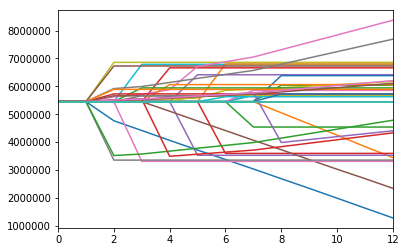

In [238]:
t = np.linspace(0,12,13)
import matplotlib.pyplot as plt
#plt.plot(t,balances[1,:])
for i in range(1,41):
    plt.plot(t[0:13],balances[i,:])
plt.margins(x=0)

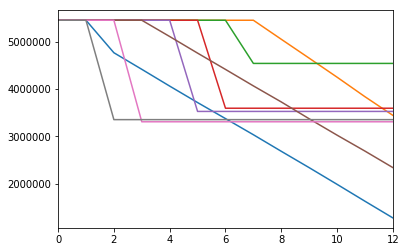

In [239]:

import matplotlib.pyplot as plt
#plt.plot(t,balances[1,:])
for i in range(1,9):
    plt.plot(t[0:13],balances[i,:])
plt.margins(x=0)

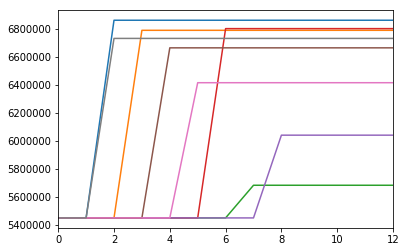

In [258]:

import matplotlib.pyplot as plt
#plt.plot(t,balances[16,:])
for i in range(9,17):
    plt.plot(t[0:13],balances[i,:])
plt.margins(x=0)

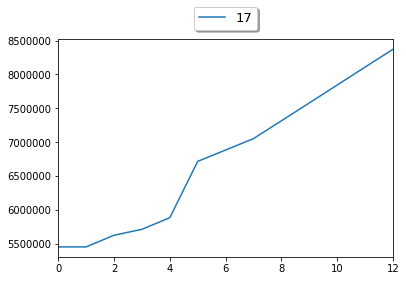

In [260]:

import matplotlib.pyplot as plt
plt.plot(t,balances[17,:],label=str(17))
#for i in range(17,25):
 #   plt.plot(t[0:13],balances[i,:],label=str(i))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          fancybox=True, shadow=True, ncol=4, fontsize=13)    
plt.margins(x=0)

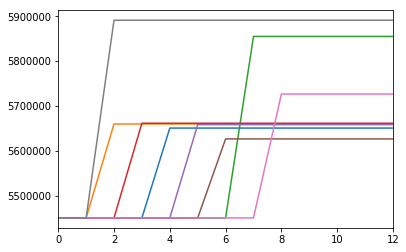

In [242]:

import matplotlib.pyplot as plt
#plt.plot(t,balances[29,:])
for i in range(25,33):
    plt.plot(t[0:13],balances[i,:])
plt.margins(x=0)

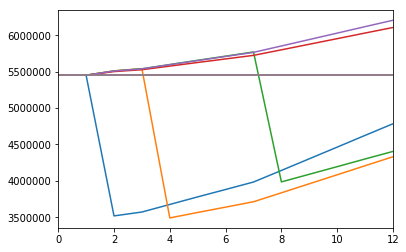

In [243]:

import matplotlib.pyplot as plt
#plt.plot(t,balances[33,:])
for i in range(33,41):
    plt.plot(t[0:13],balances[i,:])
plt.margins(x=0)

In [244]:
gas

[122857, 774431, 804495, 122857, 774495, 804495, 774431, 122729]

Text(0,0.5,'Costo [gas]')

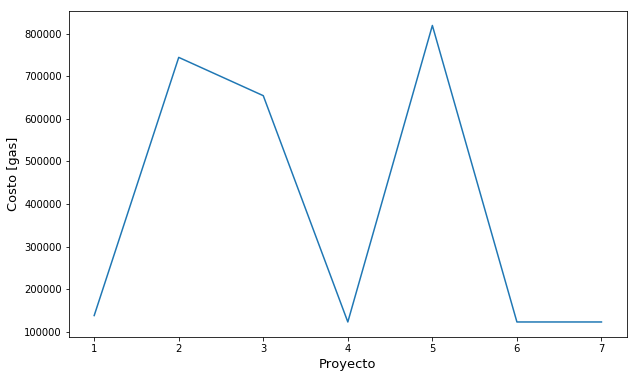

In [222]:
plt.figure(figsize=(10,6))
plt.plot([1,2,3,4,5,6,7],gas)
plt.xlabel('Proyecto', fontsize=13)
plt.ylabel('Costo [gas]', fontsize=13)

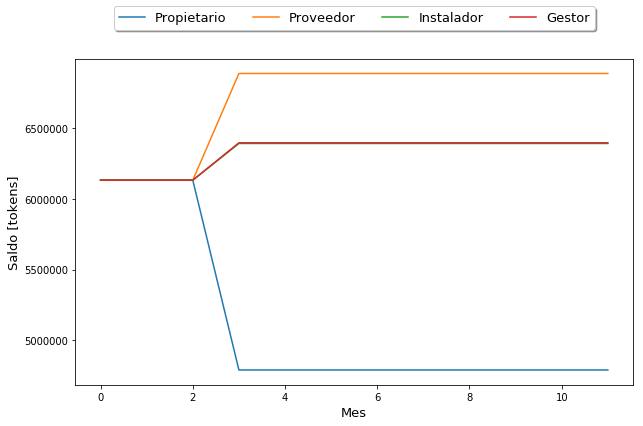

In [226]:
t = np.linspace(0,18,19)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(t[0:12],balances[6,0:12],label='Propietario')
plt.plot(t[0:12],balances[14,0:12],label='Proveedor')
plt.plot(t[0:12],balances[22,0:12],label='Instalador')
plt.plot(t[0:12],balances[30,0:12],label='Gestor')
plt.xlabel('Mes', fontsize=13)
plt.ylabel('Saldo [tokens]', fontsize=13)
#plt.legend()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          fancybox=True, shadow=True, ncol=4, fontsize=13)

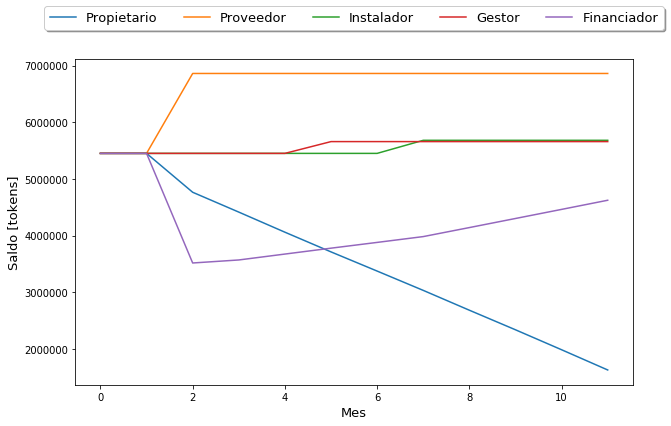

In [264]:


t = np.linspace(0,18,19)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(t[0:12],balances[1,0:12],label='Propietario')
plt.plot(t[0:12],balances[9,0:12],label='Proveedor')
plt.plot(t[0:12],balances[20,0:12],label='Instalador')
plt.plot(t[0:12],balances[29,0:12],label='Gestor')
plt.plot(t[0:12],balances[33,0:12],label='Financiador')
plt.xlabel('Mes', fontsize=13)
plt.ylabel('Saldo [tokens]', fontsize=13)
#plt.legend()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          fancybox=True, shadow=True, ncol=5, fontsize=13)

In [263]:
public_keys.duplicated()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
Name: Llave Publica, dtype: bool